# Training a linear convolution to be an advection stepper

This example demonstrates that we can (re-)learn the first-order upwind (FOU)
stencil for the 1d advection equation from trajectories created by such. We will
see that that the this two-dimesional optimization problem is quadratic convex
and that (supervised) training rollout will not change the global minimizer.

In [1]:
import jax
import jax.numpy as jnp
import optax
import equinox as eqx
import matplotlib.pyplot as plt

In [2]:
import trainax as tx

/home/felix/Documents/phd/local_repos/trainax/trainax/_general_trainer.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Let's the define the physics of the advection equation

$$ \partial_t u + c \partial_x u = 0 $$

where $c = -0.1$ is the advection speed. The domain is $\Omega = [0, 1]$ with
homogeneous Dirichlet boundary conditions. We discretize it using $N=40$
interior degrees of freedom. The size of the time step is $\Delta t = 0.1$.

In [3]:
DOMAIN_EXTENT = 1.0
NUM_POINTS = 40
DT = 0.1
ADVECTION_SPEED = -0.1

The `grid` denotes the coordinates of the interior degress of freedom.

In [4]:
grid = jnp.linspace(0.0, DOMAIN_EXTENT, NUM_POINTS + 2)[1:-1]

Let's extract the grid spacing $\Delta x$ to build the numerical reference stepper.

In [5]:
dx = grid[1] - grid[0]


def step_fou(u):
    u_right = jnp.pad(u, (0, 1), mode="constant")[1:]
    u_next = u - ADVECTION_SPEED * DT / dx * (u_right - u)
    return u_next

The initial condition is a sine arc.

In [6]:
u_0 = jnp.sin(jnp.pi * grid)

Let us integrate the initial condition for $100$ time steps and stack the states
together with the initial state in a tensor of shape `(101, 40)`.

In [7]:
trj = [u_0]
for _ in range(100):
    trj.append(step_fou(trj[-1]))

trj = jnp.stack(trj)

trj.shape

(101, 40)

Visualizing the trajectory as a spatio-temporal plot reveals that the initial
condition moves to the left before ultimately disappearing beyond the left
boundary.

What is only barely noticeable is the introduced numerical diffusion of the
first-order upwind method.

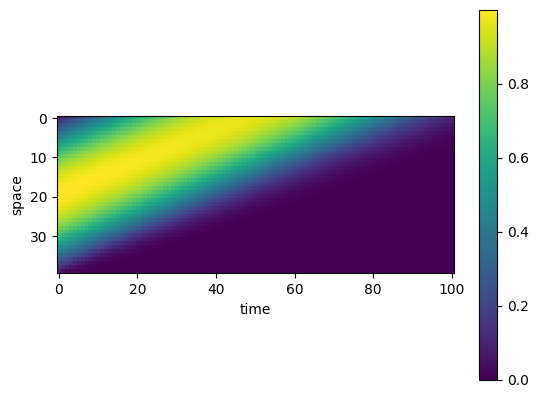

In [8]:
plt.imshow(trj.T)
plt.xlabel("time")
plt.ylabel("space")
plt.colorbar()

Now, let's instantiate a supervised trainer. Internally, it will slice the long
trajectory into windows of length $2$ which are necessary for one-step
supervised training.

Note that we need to add singleton axes for the channel and the batch (which was
not yet present in the trajectory).

We will set the batch size high such that training will always be full batch.
Adam can be chosen with a higher learning rate than usual because of the convex
quadratic nature of the optimization problem.

In [9]:
one_step_trainer = tx.trainer.SupervisedTrainer(
    trj[None, :, None, :],
    optimizer=optax.adam(1e-2),
    num_training_steps=3000,
    batch_size=200,
)

A trainer is an `Equinox` Module (=PyTree):

* A `trajectory_sub_stacker` which provides a systematic way to slice out
  specificied windows out of (batches of) trajectories. The window length has to
  be two because one-step supervised learning needs one input and one target
  placed at two consecutive time levels. This member attribute also reveals that
  there were $100$ total windows in our trajectory of length $101$. Hence, with
  the chosen batch size of $200$, the trainer will resort to full batch training
  and reduce the batch size to the maximum possible value of $100$.
* A `loss_configuration` describing how this windowed data is used. Here we have
  a `Supervised` configuration with `num_rollout_steps=1` (-> one-step
  supervised learning).
* `ref_stepper` and `residuum_fn` are required for other configurations we do
  not consider for this notebook.
* Then, the model saves optimization specific attribute like the `optimizer`,
  `num_minibatches` (equals the number of update steps that will be performed),
  `batch_size`, and potential callback functions.

In [10]:
one_step_trainer

SupervisedTrainer(
  trajectory_sub_stacker=TrajectorySubStacker(
    data_sub_trajectories=f32[100,2,1,40],
    num_total_samples=100
  ),
  loss_configuration=Supervised(
    num_rollout_steps=1,
    time_level_loss=MSELoss(batch_reduction=<function mean>),
    cut_bptt=False,
    cut_bptt_every=1,
    time_level_weights=f32[1]
  ),
  ref_stepper=None,
  residuum_fn=None,
  optimizer=GradientTransformationExtraArgs(
    init=<function init_fn>,
    update=<function update_fn>
  ),
  num_minibatches=3000,
  batch_size=200,
  callback_fn=None
)

Below is a function that builds an Ansatz linear convolution of kernel size two
with no bias.

In [11]:
def build_fou_learner(center, right):
    fou_learner = eqx.nn.Conv1d(
        1,
        1,
        2,
        padding=((0, 1),),
        use_bias=False,
        key=jax.random.PRNGKey(0),  # Dummy key because we will overwrite the init
    )
    fou_learner = eqx.tree_at(
        lambda leaf: leaf.weight,
        fou_learner,
        jnp.array([[[center, right]]]),
    )
    return fou_learner

Let us visualize the loss landscape over the two-dimensional parameter space.

In [12]:
center_range = jnp.linspace(0.0, 1.0, 50)
right_range = jnp.linspace(0.0, 1.0, 50)

We will use `Equinox`' vmapping routines for neural components to create a
"structure of arrays" approach to have 50x50 different neural emulators.

In [13]:
fou_learners = eqx.filter_vmap(
    eqx.filter_vmap(
        build_fou_learner,
        in_axes=(0, None),
    ),
    in_axes=(None, 0),
)(center_range, right_range)

This batched stepper is visible in that the weight array (that saves the
convolution kernel) has two leading batch axes of size $50$ each.

In [14]:
fou_learners

Conv1d(
  num_spatial_dims=1,
  weight=f32[50,50,1,1,2],
  bias=None,
  in_channels=1,
  out_channels=1,
  kernel_size=(2,),
  stride=(1,),
  padding=((0, 1),),
  dilation=(1,),
  groups=1,
  use_bias=False,
  padding_mode='ZEROS'
)

All trainers come with a method `full_loss` that evaluates a proposed stepper on
the entire dataset at once. We will nestedly vmap this function to obtain a
matrix of loss values.

(Be careful when using this function on very large datasets)

In [15]:
loss_landscape = eqx.filter_vmap(
    eqx.filter_vmap(one_step_trainer.full_loss),
)(fou_learners)

Then we can visualize a contour plot of the (log10) loss landscape. This reveals
the expected convex quadratic shape of the loss landscape.

Text(0, 0.5, 'Right Stencil')

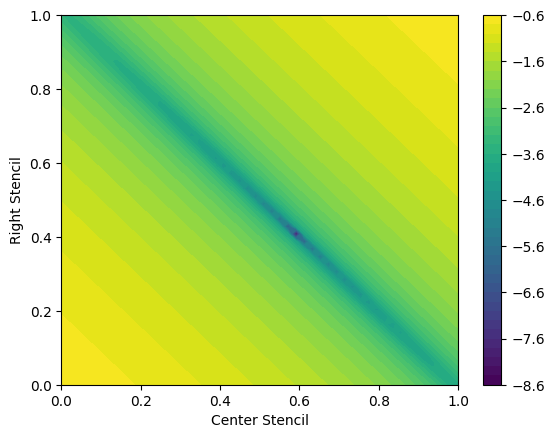

In [16]:
plt.contourf(center_range, right_range, jnp.log10(loss_landscape), levels=50)
plt.colorbar()
plt.xlabel("Center Stencil")
plt.ylabel("Right Stencil")

Let's perform the corresponding optimization/training. For this, we will choose
one sample stepper that we instantiate close to expected global optimizer.

In [17]:
trained_stepper, loss_history = one_step_trainer(
    build_fou_learner(0.4, 0.5),
    jax.random.PRNGKey(0),
)

batch size 200 is larger than the total number of samples 100
Performing full batch training


E: 00000, B: 00000:   0%|          | 0/3000 [00:00<?, ?it/s]

Visualizing the training progress indicates a full convergence all the way down
to double floating machine precision.

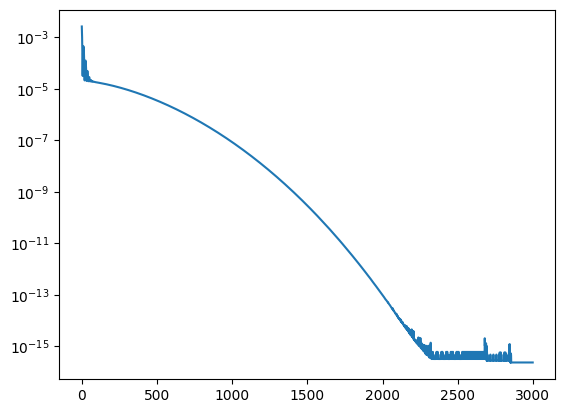

In [18]:
plt.semilogy(loss_history)

Below, we inspect the found weight. Up to some final rounding error, we found
the estimate

$$ [0.59, 0.41] $$

This is exactly the FOU stencil!

In [19]:
trained_stepper.weight

Array([[[0.5899999, 0.4100001]]], dtype=float32)

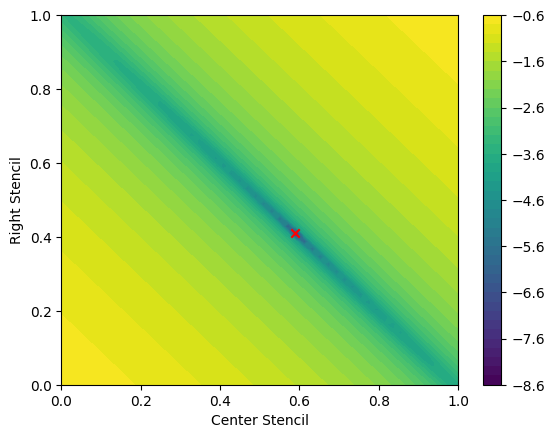

In [20]:
plt.contourf(center_range, right_range, jnp.log10(loss_landscape), levels=50)
plt.colorbar()
plt.xlabel("Center Stencil")
plt.ylabel("Right Stencil")
plt.scatter(
    trained_stepper.weight[0, 0, 0],
    trained_stepper.weight[0, 0, 1],
    marker="x",
    color="red",
)

In [21]:
fou_stencil = jnp.array([[[1 + ADVECTION_SPEED * DT / dx, -ADVECTION_SPEED * DT / dx]]])

In [22]:
fou_stencil

Array([[[0.59000003, 0.41      ]]], dtype=float32)

# Beyond one-step training

Let's see how the optimization landscape changes if introduce increasing
training rollout.

In [23]:
one_step_trainer = tx.trainer.SupervisedTrainer(
    trj[None, :, None, :],
    optimizer=optax.adam(1e-2),
    num_training_steps=3000,
    batch_size=200,
    num_rollout_steps=1,
)
two_step_trainer = tx.trainer.SupervisedTrainer(
    trj[None, :, None, :],
    optimizer=optax.adam(1e-2),
    num_training_steps=3000,
    batch_size=200,
    num_rollout_steps=2,
)
three_step_trainer = tx.trainer.SupervisedTrainer(
    trj[None, :, None, :],
    optimizer=optax.adam(1e-2),
    num_training_steps=3000,
    batch_size=200,
    num_rollout_steps=3,
)
four_step_trainer = tx.trainer.SupervisedTrainer(
    trj[None, :, None, :],
    optimizer=optax.adam(1e-2),
    num_training_steps=3000,
    batch_size=200,
    num_rollout_steps=4,
)

In [24]:
one_step_loss_landscape = eqx.filter_vmap(
    eqx.filter_vmap(one_step_trainer.full_loss),
)(fou_learners)
two_step_loss_landscape = eqx.filter_vmap(
    eqx.filter_vmap(two_step_trainer.full_loss),
)(fou_learners)
three_step_loss_landscape = eqx.filter_vmap(
    eqx.filter_vmap(three_step_trainer.full_loss),
)(fou_learners)
four_step_loss_landscape = eqx.filter_vmap(
    eqx.filter_vmap(four_step_trainer.full_loss),
)(fou_learners)

Visualizing all landscapes together shows that the global optimizer seemingly
does not move, we seemingly maintain convexity, only the landscape becomes
steeper.

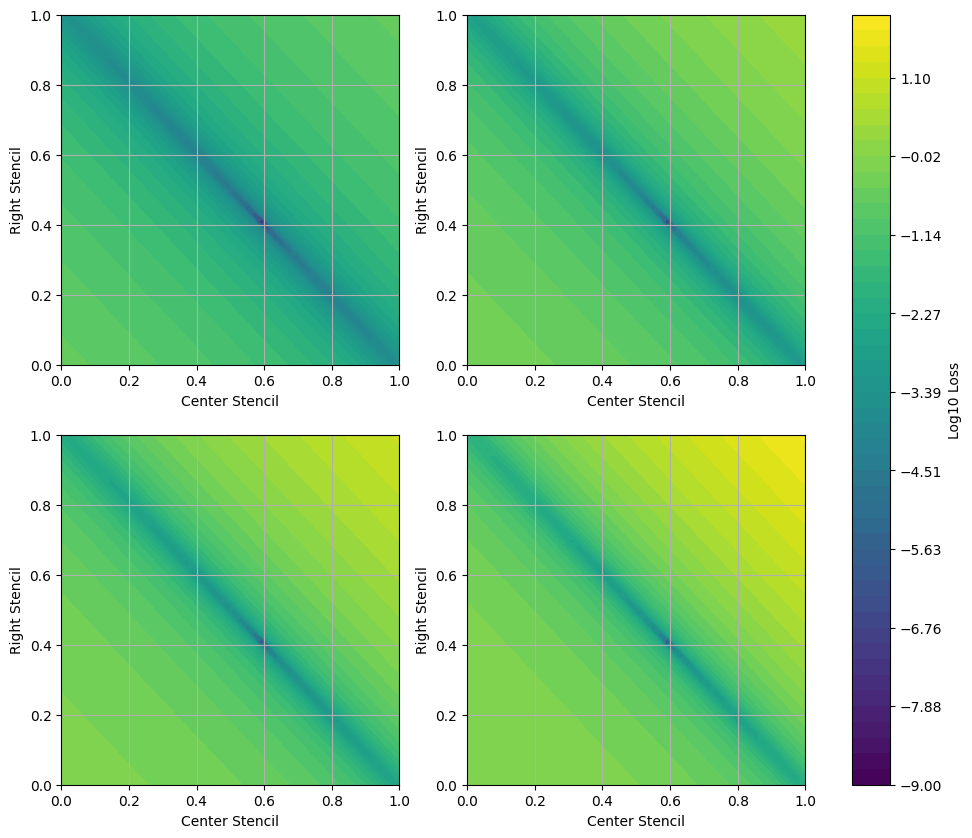

In [25]:
fig, ax_s = plt.subplots(2, 2, figsize=(12, 10))

for ax, loss_landscape, trainer in zip(
    ax_s.flat,
    [
        one_step_loss_landscape,
        two_step_loss_landscape,
        three_step_loss_landscape,
        four_step_loss_landscape,
    ],
    [one_step_trainer, two_step_trainer, three_step_trainer, four_step_trainer],
):
    im = ax.contourf(
        center_range,
        right_range,
        jnp.log10(loss_landscape),
        levels=jnp.linspace(-9, 2, 50),
    )
    ax.set_xlabel("Center Stencil")
    ax.set_ylabel("Right Stencil")
    ax.grid()

fig.colorbar(im, ax=ax_s.ravel().tolist(), label="Log10 Loss")

Let us also perform all corresponding optimizations to confirm that the global
optimizer indeed does not change.

In [26]:
one_step_trained_stepper, one_step_loss_history = one_step_trainer(
    build_fou_learner(0.4, 0.5),
    jax.random.PRNGKey(0),
)
two_step_trained_stepper, two_step_loss_history = two_step_trainer(
    build_fou_learner(0.4, 0.5),
    jax.random.PRNGKey(0),
)
three_step_trained_stepper, three_step_loss_history = three_step_trainer(
    build_fou_learner(0.4, 0.5),
    jax.random.PRNGKey(0),
)
four_step_trained_stepper, four_step_loss_history = four_step_trainer(
    build_fou_learner(0.4, 0.5),
    jax.random.PRNGKey(0),
)

batch size 200 is larger than the total number of samples 100
Performing full batch training


E: 00000, B: 00000:   0%|          | 0/3000 [00:00<?, ?it/s]

batch size 200 is larger than the total number of samples 99
Performing full batch training


E: 00000, B: 00000:   0%|          | 0/3000 [00:00<?, ?it/s]

batch size 200 is larger than the total number of samples 98
Performing full batch training


E: 00000, B: 00000:   0%|          | 0/3000 [00:00<?, ?it/s]

batch size 200 is larger than the total number of samples 97
Performing full batch training


E: 00000, B: 00000:   0%|          | 0/3000 [00:00<?, ?it/s]

All the same optima are found.

In [27]:
one_step_trained_stepper.weight, two_step_trained_stepper.weight, three_step_trained_stepper.weight, four_step_trained_stepper.weight,

(Array([[[0.5899999, 0.4100001]]], dtype=float32),
 Array([[[0.5899999, 0.4100001]]], dtype=float32),
 Array([[[0.5899999, 0.4100001]]], dtype=float32),
 Array([[[0.5899999, 0.4100001]]], dtype=float32))

Qualitatively, all optimizations progress similarly but with scaled factors.
This is because, we supplied `None` to the `time_level_weights` argument of the
`SupervisedTrainer`, this will lead to a uniform weighting of all time levels
(summation instead of mean).

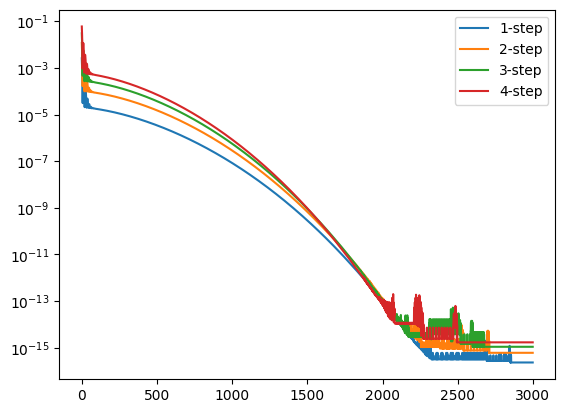

In [28]:
plt.semilogy(one_step_loss_history, label="1-step")
plt.semilogy(two_step_loss_history, label="2-step")
plt.semilogy(three_step_loss_history, label="3-step")
plt.semilogy(four_step_loss_history, label="4-step")
plt.legend()